# Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import torchtext

import numpy as np

import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import matplotlib.pyplot as plt

import os

from PIL import Image

# Load Train-Valid Data

## Read files

In [ ]:
def process_file(file_path):
    if transferLearning:
        imgT = torch.load(file_path)
    else:
        img = Image.open(ipath).convert('L')
        img = img.resize(imgSize)
        imgT = transform(img)

    for j in range(classDup[i]):
        pages.append(imgT)
        labels.append(i)
        classCount[i] += 1

def process_directory(directory_path):
    # List all files and subdirectories in the current directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        # Check if the item is a file or directory
        if os.path.isfile(item_path):
            process_file(item_path)
        elif os.path.isdir(item_path):
            # Recursively process subdirectories
            process_directory(item_path)

In [ ]:
# Expected folder structure:
# root
# | BAROQUE
# | | <First name>,_<Last name>
# | | | <title>
# | | | | <pngs>
# | CLASSICAL
# | | ...
# | ROMANTIC
# | | ...



# ***Tunables***
root = "./APS360Data/resnetEmb"
transferLearning = True # turn on to read embeddings
# How many duplicates do we want fo each class
classDup = [3, 3, 1]
# ***^Tunables***

baroqueFolder = root + "/BAROQUE"
classicalFolder = root + "/CLASSICAL"
romanticFolder = root + "/ROMANTIC"

# Global variables
pages = []
labels = []
classCount = [0,0,0]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]
)

i = 0
for i, folder in enumerate([baroqueFolder,
                            classicalFolder,
                            romanticFolder],
                           0):
    process_directory(folder)



print("Loaded %d sheets and %d labels" % (len(pages), len(labels)))
print("Classes:", classCount)

Loaded 2641 sheets and 2641 labels
Classes: [834, 966, 841]


## Process and split

In [ ]:
# Returns a tensors and labels
class MusicDataset(Dataset):
    def __init__(self, sheets, labels):
        self.sheets = sheets
        self.labels = labels


    def __len__(self):
        return len(self.sheets)

    def __getitem__(self, index):
        sheet = self.sheets[index]
        label = self.labels[index]


        return sheet, label

In [ ]:
musicDataset = MusicDataset(pages, labels)

In [ ]:
# Sanity check, size should be [1, pages, channels, height, width]
dataLoader = DataLoader(musicDataset, batch_size = 1)

i = 0
for data in dataLoader:
    if i <= 11:
        print(data[0].size())
    # Otherwise, keep running and see if the read works all the way
    i += 1

torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])


In [ ]:
# Then, we will split the data between training, and valid, no testing
# In this case, we choose to split it in 80:20

torch.manual_seed(705)

trainSize = int(0.8 * len(musicDataset))
validSize = int(len(musicDataset) - trainSize)

# Split the data randomly so the likelyhood of a data set
# missing a class is low
trainSet, validSet = torch.utils.data.random_split(musicDataset,
                                                   [trainSize,
                                                    validSize])

print("We have %d training images, %d validation images \n" \
      "out of %d images" %
      (trainSize, validSize, len(musicDataset)))

We have 2112 training images, 529 validation images 
out of 2641 images


# Model Classes

## ResNet_Single

In [ ]:
# Define the main classification model
# accepts a tensor of batchx2048x7x7
class ResNet_Single(nn.Module):
    def __init__(self, num_classes, device):
        super(ResNet_Single, self).__init__()
        self.name = "ResNet_Single"
        self.device = device

        self.fc1 = nn.Linear(100352, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, num_classes)



    def forward(self, x):
        x = x.view(-1, 100352)

        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = x.squeeze(1) # Flatten to [batch_size]
        return x

## ResNet_CNN_Single

In [ ]:
# Define the main classification model
# accepts a tensor of batchx2048x7x7
class ResNet_CNN_Single(nn.Module):
    def __init__(self, num_classes, device):
        super(ResNet_CNN_Single, self).__init__()
        self.name = "ResNet_CNN_Single"
        self.device = device

        self.cnn1 = nn.Conv2d(2048, 4096, 3, padding = 1, stride = 3)


        self.fc1 = nn.Linear(36864, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, num_classes)



    def forward(self, x):
        x = F.relu(self.cnn1(x))

        x = x.view(-1, 36864)

        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = x.squeeze(1) # Flatten to [batch_size]
        return x

## ResNet_CNN_Pool_Single

In [ ]:
# Define the main classification model
# accepts a tensor of batchx2048x7x7
class ResNet_CNN_Pool_Single(nn.Module):
    def __init__(self, num_classes, device):
        super(ResNet_CNN_Pool_Single, self).__init__()
        self.name = "ResNet_CNN_Pool_Single"
        self.device = device

        self.cnn1 = nn.Conv2d(2048, 4096, 3, padding = 1, stride = 3)

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, num_classes)



    def forward(self, x):
        x = F.relu(self.cnn1(x))
        x = self.pool(x)

        x = x.view(-1, 4096)

        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = x.squeeze(1) # Flatten to [batch_size]
        return x

## ResNet_CNN_Pool_Large_Single

In [ ]:
# Define the main classification model
# accepts a tensor of batchx2048x7x7
class ResNet_CNN_Pool_Large_Single(nn.Module):
    def __init__(self, num_classes, device):
        super(ResNet_CNN_Pool_Large_Single, self).__init__()
        self.name = "ResNet_CNN_Pool_Large_Single"
        self.device = device

        self.cnn1 = nn.Conv2d(2048, 4096, 3, padding = 1)

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, num_classes)



    def forward(self, x):
        x = F.relu(self.cnn1(x))
        x = self.pool(x)

        x = x.view(-1, 4096)

        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = x.squeeze(1) # Flatten to [batch_size]
        return x

# Evaluation Functions

## Evaluate

In [ ]:
# A helper function used to evaluate a *trained* network on a certain set
# Based on Lab2
def evaluate(net, loader, criterion):
    totalLoss = 0
    totalErr = 0
    totalItems = 0
    totalTrainAcc = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        inputC = inputs.clone().to(net.device)
        labelC = labels.clone().to(net.device)

        outputs = net(inputC)
        loss = criterion(outputs, labelC)

        outLabels = torch.argmax(outputs, dim = 1)
        corr = outLabels.squeeze() != labelC
        tbs = len(labels) # This batch size


        totalErr += int(corr.sum())
        totalLoss += loss.item()
        totalTrainAcc += 0#accuracy_score(labels.view(tbs, -1).cpu(),
                         #               outLabels.view(tbs, -1).cpu())
        totalItems += tbs

    err = float(totalErr) / totalItems
    loss = float(totalLoss) / (i+1)
    acc = totalTrainAcc / (i+1)

    return err, loss, acc

## Get model path

In [ ]:
def get_model_path (name, batchSize, learningRate, epoch):
    return "model_%s_bs%d_lr%.6f_epoch%d" % (name,
                                             batchSize,
                                             learningRate,
                                             epoch)

## Plotting

In [ ]:
# Plot the training curve of given model path
# Run train_net first to ensure the data is there
def plot_training_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))

    # remove the starting 1
    train_err = train_err[1:]
    val_err = val_err[1:]
    train_loss = train_loss[1:]
    val_loss = val_loss[1:]
    train_acc = train_acc[1:]
    val_acc = val_acc[1:]

    plt.title("Train vs Validation Error, high=bad")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train", color = 'orange')
    plt.plot(range(1,n+1), val_err, label="Validation", color = 'gold')
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Loss, high=bad")
    plt.plot(range(1,n+1), train_loss, label="Train", color = 'red')
    plt.plot(range(1,n+1), val_loss, label="Validation", color = 'magenta')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    #plt.title("Train vs Validation Accuracy, high=good")
    #plt.plot(range(1,n+1), train_acc, label="Train", color = 'blue')
    #plt.plot(range(1,n+1), val_acc, label="Validation", color = 'cyan')
    #plt.xlabel("Epoch")
    #plt.ylabel("Accuracy")
    #plt.legend(loc='best')
    #plt.show()

# Train Function

In [ ]:
def train_net(trainData,
              validData,
              model, batchSize = 16, learningRate = 0.01, numEpochs = 5):
    print("model.device:", model.device)
    # Create datasets and dataloaders
    trainLoader = DataLoader(trainData,
                             batch_size=batchSize,
                             shuffle=True)

    validLoader = DataLoader(validData,
                             batch_size=batchSize,
                             shuffle=True)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    # Some arrays to record the performance
    # Err: error rate;
    # Loss: mean loss function output;
    # Acc: average sklearn.metrics.accuracy_score
    # The [0] position is not used, a small cost for readability
    trainErr = np.zeros(numEpochs+1)
    trainLoss = np.zeros(numEpochs+1)
    valErr = np.zeros(numEpochs+1)
    valLoss = np.zeros(numEpochs+1)
    trainAcc = np.zeros(numEpochs+1)
    valAcc = np.zeros(numEpochs+1)

    # Training loop
    start_time = time.time()
    for epoch in range(1, numEpochs + 1):
        totalTrainLoss = 0.0
        totalTrainErr = 0.0
        totalTrainAcc = 0.0
        totalItemEpoch = 0
        b = 1

        for batch, labels in trainLoader:
            print("\rTraining batch %d of %d" % (b, len(trainLoader)), end = '')
            b += 1

            batchC = batch.clone().to(model.device)
            labelC = labels.clone().to(model.device)

            # Forward pass
            outputs = model(batchC)

            # Compute the loss
            loss = criterion(outputs, labelC)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluation
            outLabels = torch.argmax(outputs, dim = 1)
            corr = outLabels.squeeze() != labelC
            tbs = len(batch) # This batch size

            totalTrainErr += int(corr.sum())
            totalTrainLoss += loss.item()
            totalTrainAcc += 0#accuracy_score(labels.view(tbs, -1).cpu(),
                              #              outLabels.view(tbs, -1).cpu())
            totalItemEpoch += tbs

        # Evaluate each epoch
        trainErr[epoch] = float(totalTrainErr) / totalItemEpoch
        trainLoss[epoch] = float(totalTrainLoss) / (len(trainLoader))
        trainAcc[epoch] = float(totalTrainAcc) / (len(trainLoader))
        valErr[epoch], valLoss[epoch], valAcc[epoch] = evaluate(model,
                                                                validLoader,
                                                                criterion)
        # Print report
        print("\nEpoch %d:\n" \
              "train err %.6f, train loss %.6f, train acc %.6f;\n" \
              "valid err %.6f, valid loss %.6f, valid acc %.6f;"
              % (epoch,
                 trainErr[epoch], trainLoss[epoch], trainAcc[epoch],
                 valErr[epoch], valLoss[epoch], valAcc[epoch]))

        # Checkpoint every 5 epochs
        if (epoch % 5 == 0):
            modelPath = get_model_path(model.name,
                                       batchSize,
                                       learningRate,
                                       epoch)
            torch.save(model.state_dict(), modelPath)
            print("saved %s, time elapsed since start %.2f"
                  % (modelPath, time.time() - start_time))

    modelPath = get_model_path(model.name, batchSize, learningRate, epoch)
    # save the csvs
    np.savetxt("{}_train_err.csv".format(modelPath), trainErr)
    np.savetxt("{}_train_loss.csv".format(modelPath), trainLoss)
    np.savetxt("{}_val_err.csv".format(modelPath), valErr)
    np.savetxt("{}_val_loss.csv".format(modelPath), valLoss)
    np.savetxt("{}_train_acc.csv".format(modelPath), trainAcc)
    np.savetxt("{}_val_acc.csv".format(modelPath), valAcc)

# Hyper Search

In [ ]:
def train_and_plot(trainData,
                   validData,
                   model, batchSize = 16, learningRate = 0.01, numEpochs = 5):

    model = model.to(model.device)
    # Preload a validLoader for confusion matrix plotting
    validLoader = DataLoader(validData, batch_size=batchSize, shuffle=True)

    path = get_model_path(model.name, batchSize, learningRate, numEpochs)

    print("\n\nTraining and Ploting", path)

    train_net(trainData,
              validData,
              model, batchSize, learningRate, numEpochs)
    plot_training_curve(path)
    # plot_confusion_matrix(model, validLoader)

    print("\n\n---\n\n")

def summarise_output(modelClass,
                     batchSize, learningRate, numEpochs,
                     num_classes, device):
    model = modelClass(num_classes, device)
    path = get_model_path(model.name, batchSize, learningRate, numEpochs)

    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    minValErr = np.min(val_err[1:])
    minValLoss = np.min(val_loss[1:])
    minValEPoint = np.argmin(val_err[1:]) + 1
    minValLPoint = np.argmin(val_loss[1:]) + 1

    print("%s \n %.3f %.3f %d %d" \
          % (model.name, minValErr, minValLoss,
            minValEPoint, minValLPoint))


In [ ]:
num_classes = 3  # Number of music styles (Baroque/Classic/Romantic)
device = "cuda"

In [ ]:
# List of tuples of format (model, batchSize, learningRate, numEpochs)
hyperList = [
    (ResNet_CNN_Pool_Single, 16, 0.00001, 20),
    (ResNet_CNN_Pool_Single, 16, 0.001, 20),
    (ResNet_Single, 16, 0.00001, 20)
]

In [ ]:
for hyper in hyperList:
    train_and_plot(trainData = trainSet,
                   validData = validSet,
                   model = hyper[0](num_classes, device),
                   batchSize =  hyper[1],
                   learningRate = hyper[2],
                   numEpochs = hyper[3])

In [ ]:
for hyper in hyperList:
    summarise_output(hyper[0], hyper[1], hyper[2], hyper[3],
                    num_classes, device)

ResNet_CNN_Pool_Single 
 0.115 0.374 0 16
ResNet_CNN_Pool_Single 
 0.104 0.540 0 1
ResNet_Single 
 0.101 0.353 0 12


## Continue Training

In [ ]:
index = 0 # The index in the hyperList you want to continue training
epoch = 10 # From which epoch to continue
newBatchSize = 16
newLr = 1e-6
newEpochs = 10


hyper = hyperList[index]

model = hyper[0](num_classes, device).to(device)

path = get_model_path(model.name,
                      hyper[1],
                      hyper[2],
                      e)
state = torch.load(path)

model.load_state_dict(state)

model.name = model.name + "Cont"

hyperList.append((hyper[0], newBatchSize, newLr, newEpochs))

train_and_plot(trainData = trainSet,
               validData = validSet,
               model = model,
               batchSize =  newBatchSize,
               learningRate = newLr,
               numEpochs = newEpochs)

# Final Testing

## Helper Functions

In [ ]:
def evaluate_and_confuse(net, loader, criterion):
    totalLoss = 0
    totalErr = 0
    totalItems = 0
    totalTrainAcc = 0
    totalLabels = []
    totalPredictions = []
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        inputC = inputs.clone().to(net.device)
        labelC = labels.clone().to(net.device)

        outputs = net(inputC)
        loss = criterion(outputs, labelC)

        outLabels = torch.argmax(outputs, dim = 1)
        corr = outLabels.squeeze() != labelC
        tbs = len(labels) # This batch size


        totalErr += int(corr.sum())
        totalLoss += loss.item()
        totalTrainAcc += 0#accuracy_score(labels.view(tbs, -1).cpu(),
                         #               outLabels.view(tbs, -1).cpu())
        totalItems += tbs
        totalLabels.append(labels)
        totalPredictions.append(outLabels)

    err = float(totalErr) / totalItems
    loss = float(totalLoss) / (i+1)
    acc = totalTrainAcc / (i+1)

    print(totalErr)

    truth = torch.cat(totalLabels)
    pred = torch.cat(totalPredictions)

    # Create a confusion matrix
    confusion_mat = confusion_matrix(truth.cpu(), pred.cpu())

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=[f"Class {i}" for i in range(3)],
                yticklabels=[f"Class {i}" for i in range(3)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


    classLabels = [0,1,2]
    # Calculate precision, recall, and F1 score for each class
    precision, recall, f1_score, _ = \
        precision_recall_fscore_support(truth.cpu(),
                                        pred.cpu(),
                                        labels=classLabels,
                                        average=None)

    print("Class precision recall f1")
    for i in range(len(classLabels)):
        print(i, precision[i], recall[i], f1_score[i])
    return err, loss, acc

In [ ]:
def process_file_test(file_path):
    if transferLearning:
        imgT = torch.load(file_path)
    else:
        img = Image.open(ipath).convert('L')
        img = img.resize(imgSize)
        imgT = transform(img)

    tpages.append(imgT)
    tlabels.append(i)

def process_directory_test(directory_path):
    # List all files and subdirectories in the current directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        # Check if the item is a file or directory
        if os.path.isfile(item_path):
            process_file_test(item_path)
        elif os.path.isdir(item_path):
            # Recursively process subdirectories
            process_directory_test(item_path)

## Load test data

In [ ]:
testPath = "./test360/testEmb/"

baroqueFolderT = testPath + "BAROQUE"
classicalFolderT = testPath + "CLASSICAL"
romanticFolderT = testPath + "ROMANTIC"


tpages = []
tlabels = []

def process_file(file_path):
    tpages.append(torch.load(file_path))
    tlabels.append(i)


def process_directory(directory_path):
    # List all files and subdirectories in the current directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        # Check if the item is a file or directory
        if os.path.isfile(item_path):
            process_file(item_path)
        elif os.path.isdir(item_path):
            # Recursively process subdirectories
            process_directory(item_path)

i = 0

for i, folder in enumerate([baroqueFolderT,
                            classicalFolderT,
                            romanticFolderT],
                           0):
    process_directory(folder)

print(len(tpages), len(tlabels))

122 122


In [ ]:
testDataset = MusicDataset(tpages, tlabels)

## Final evaluation

In [ ]:
hyperList

[(__main__.ResNet_CNN_Pool_Single, 16, 1e-05, 20),
 (__main__.ResNet_CNN_Pool_Single, 16, 0.001, 20),
 (__main__.ResNet_Single, 16, 1e-05, 20)]

68


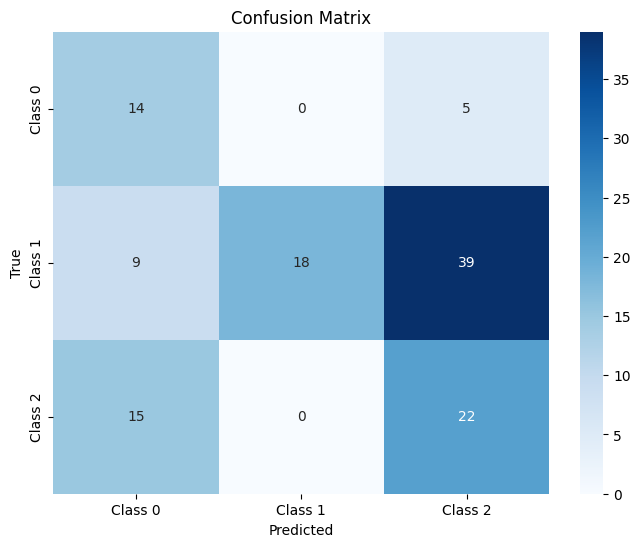

Class precision recall f1
0 0.3684210526315789 0.7368421052631579 0.49122807017543857
1 1.0 0.2727272727272727 0.42857142857142855
2 0.3333333333333333 0.5945945945945946 0.42718446601941745
(0.5573770491803278, 1.2102139197045663, 0.0)


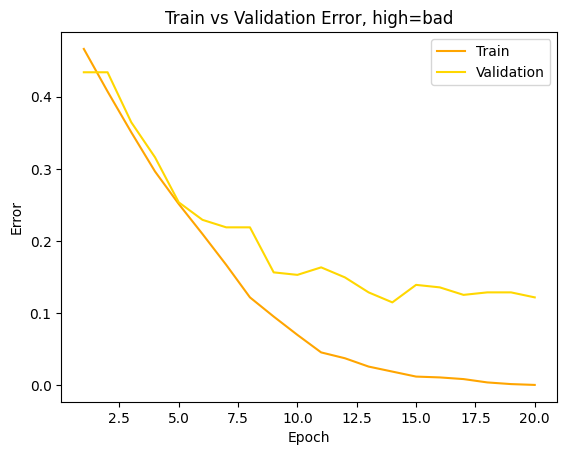

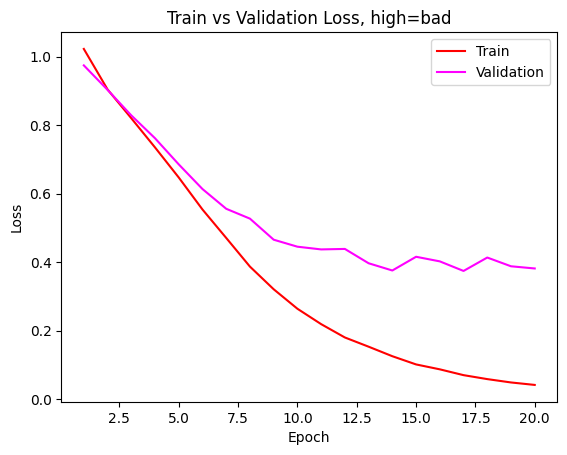

62


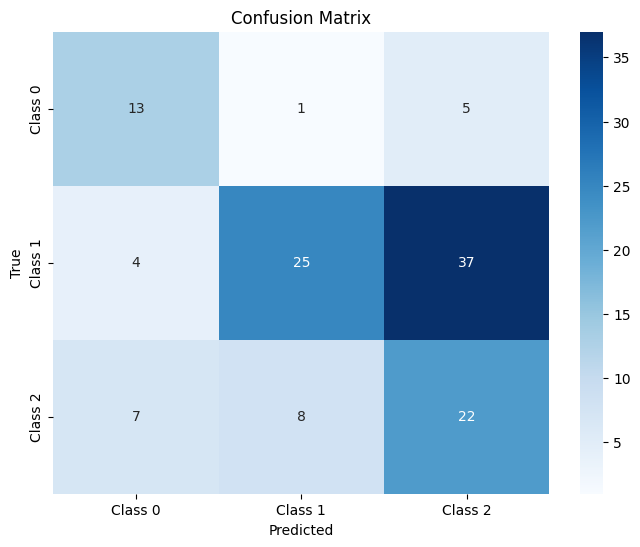

Class precision recall f1
0 0.5416666666666666 0.6842105263157895 0.6046511627906976
1 0.7352941176470589 0.3787878787878788 0.5
2 0.34375 0.5945945945945946 0.4356435643564357
(0.5081967213114754, 3.234522105397766, 0.0)


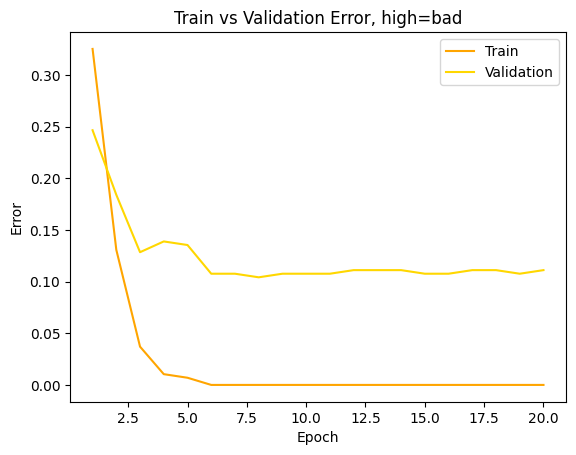

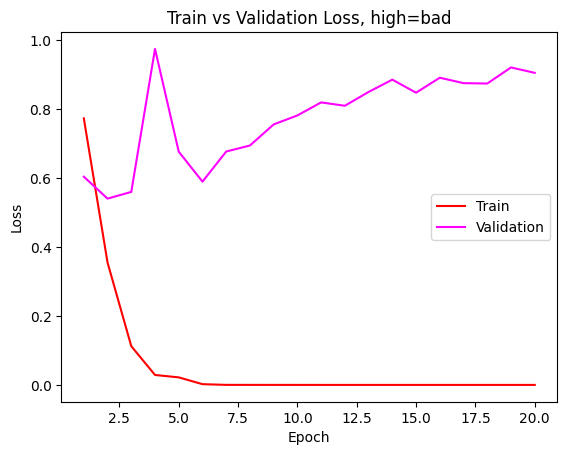

67


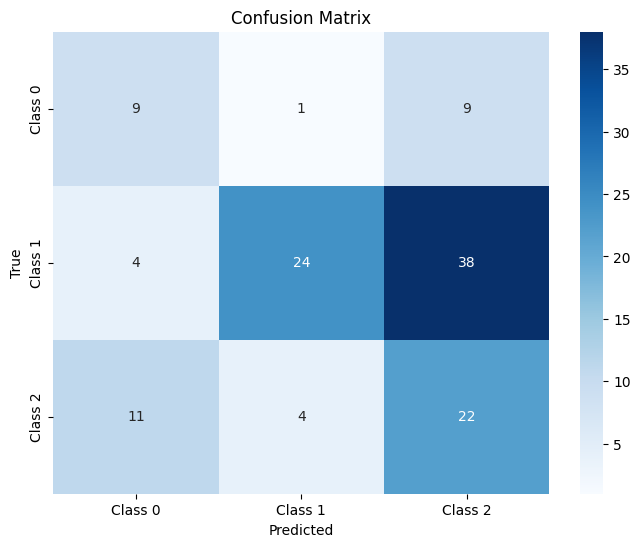

Class precision recall f1
0 0.375 0.47368421052631576 0.4186046511627907
1 0.8275862068965517 0.36363636363636365 0.5052631578947369
2 0.3188405797101449 0.5945945945945946 0.4150943396226415
(0.5491803278688525, 1.2681137220552343, 0.0)


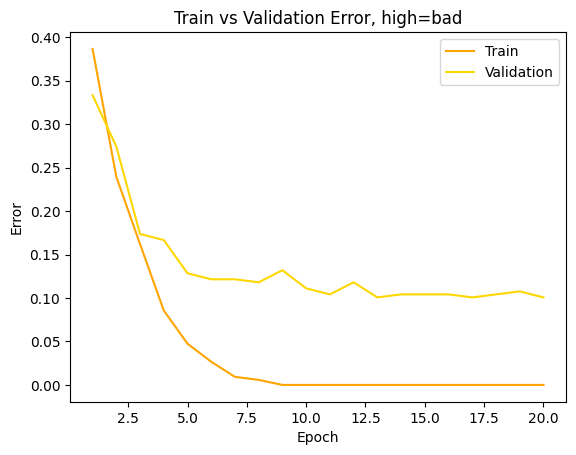

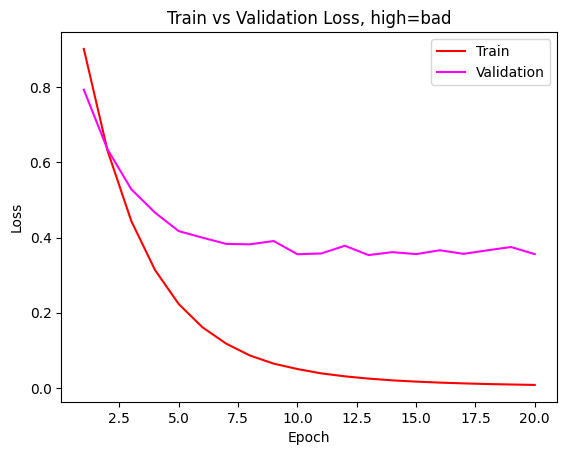

73


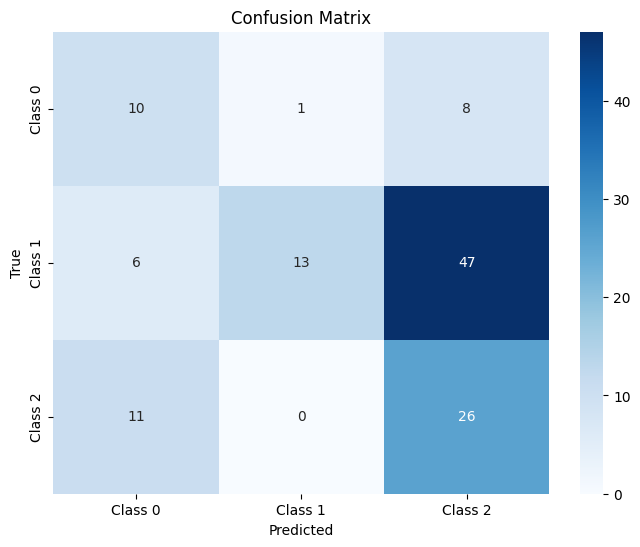

Class precision recall f1
0 0.37037037037037035 0.5263157894736842 0.43478260869565216
1 0.9285714285714286 0.19696969696969696 0.32499999999999996
2 0.32098765432098764 0.7027027027027027 0.4406779661016949
(0.5983606557377049, 1.5709728450661327, 0.0)


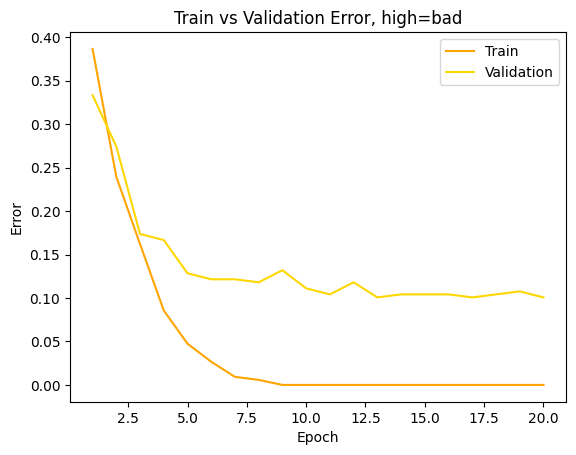

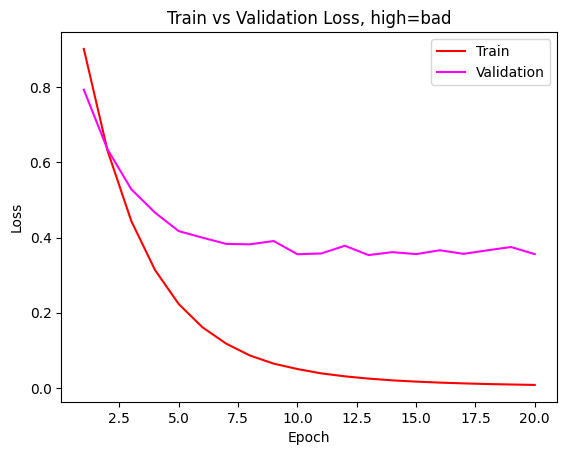

In [ ]:
# For each model trained in hyper List, pick a
# epoch number (that is a checkpoint) to be tested
# or a tuple or numbers
testEpochsList = [10, 10, (10, 15)]


for i, hyper in enumerate(hyperList, 0):
    epochs = testEpochsList[i]
    if (not isinstance(epochs, tuple)):
        epochs = (epochs,)

    for e in epochs:
        model = hyper[0](num_classes, device).to(device)

        path = get_model_path(model.name,
                              hyper[1],
                              hyper[2],
                              e)
        state = torch.load(path)

        model.load_state_dict(state)

        validLoader = DataLoader(testDataset,
                                 batch_size=1)

        print(evaluate_and_confuse(model,
                                   validLoader,
                                   nn.CrossEntropyLoss()))


        path2 = get_model_path(model.name,
                               hyper[1],
                               hyper[2],
                               hyper[3])
        plot_training_curve(path2)

        print("\n---\n")
